In [1]:
%pip install geopandas rasterio matplotlib scikit-learn pandas pyimpute xgboost lightgbm geojson


Note: you may need to restart the kernel to use updated packages.


# Species Distribution Data Loading

In [2]:
import os 
os.makedirs("inputs", exist_ok = True)
os.makedirs("outputs", exist_ok = True)

In [3]:
import geopandas as gpd
import shutil
import glob

filetype = 'geojson'

for f in sorted(glob.glob('data/' + filetype + '/*')):
    shutil.copy(f,'inputs/')

pa = gpd.GeoDataFrame.from_file('inputs/CardellinaPusilla.' + filetype)
pa.sample(5) # GeoDataFrame for the species

,CLASS,geometry
2130,1.0,POINT (-114.39192 32.63317)
558,0.0,POINT (-114.06250 40.02083)
98,1.0,POINT (-121.97607 38.51500)
2865,0.0,POINT (-115.77083 31.56250)
858,1.0,POINT (-118.04519 34.03473)


In [4]:
print("number of duplicates: ", pa.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", pa['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(pa.crs))
print("{} observations with {} columns".format(*pa.shape))

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: EPSG:4326
3000 observations with 2 columns


We can map the species presences (`pa==1`).

<Axes: >

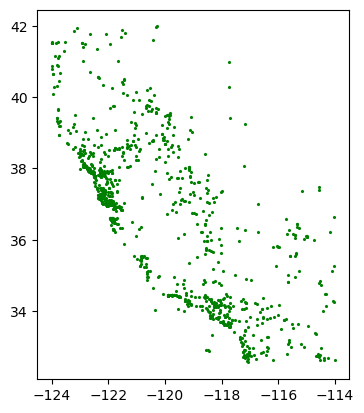

In [5]:
pa[pa.CLASS == 1].plot(marker='*', color='green', markersize=2)

And we can map the background points (`pa == 0`).

<Axes: >

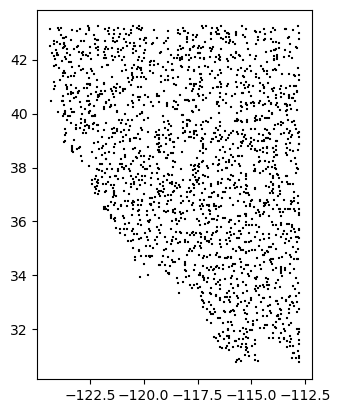

In [6]:
pa[pa.CLASS == 0].plot(marker='+', color='black', markersize=1)

# Climate Data Loading and Preprocessing

Load Climate Data

In [7]:
# grab climate features - cropped to joshua tree study area
for f in sorted(glob.glob('data/bioclim/bclim*.asc')):
    shutil.copy(f,'inputs/')
raster_features = sorted(glob.glob(
    'inputs/bclim*.asc'))
# check number of features 
print('\nThere are', len(raster_features), 'raster features.')



There are 19 raster features.


In [8]:
from pyimpute import load_training_vector
from pyimpute import load_targets
train_xs, train_y = load_training_vector(pa, raster_features, response_field='CLASS')
target_xs, raster_info = load_targets(raster_features)
train_xs.shape, train_y.shape # check shape, does it match the size above of the observations?


((3000, 19), (3000,))

In [35]:
import pandas as pd
import numpy as np

df = pd.DataFrame(train_xs)

# Check for Nan (why is there a NaN at all?)
#df_null = df.isnull().unstack()
#t = df_null[df_null]
#t

row_index = df.index[df.isna().any(axis=1)].tolist()

train_xs_mod = np.delete(train_xs, row_index, axis=0)
train_y_mod = np.delete(train_y, row_index, axis=0)

and we implemement several `scikit-learn` classifiers:

In [36]:
# import machine learning classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

CLASS_MAP = {
    'rf': (RandomForestClassifier()),
    'et': (ExtraTreesClassifier()),
    'xgb': (XGBClassifier()),
    'lgbm': (LGBMClassifier())
    }

from pyimpute import impute
from sklearn import model_selection
# model fitting and spatial range prediction
for name, (model) in CLASS_MAP.items():
    # cross validation for accuracy scores (displayed as a percentage)
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs_mod, train_y_mod, cv=kf, scoring='accuracy')
    print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    
    # spatial prediction
    model.fit(train_xs_mod, train_y_mod)
    os.makedirs('outputs/' + name + '-images', exist_ok=True)
    impute(target_xs, model, raster_info, outdir='outputs/' + name + '-images',
           class_prob=True, certainty=True)

rf 5-fold Cross Validation Accuracy: 82.09 (+/- 1.84)
et 5-fold Cross Validation Accuracy: 81.79 (+/- 1.91)
xgb 5-fold Cross Validation Accuracy: 80.89 (+/- 2.07)
[LightGBM] [Info] Number of positive: 806, number of negative: 1593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4294
[LightGBM] [Info] Number of data points in the train set: 2399, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.335973 -> initscore=-0.681291
[LightGBM] [Info] Start training from score -0.681291
[LightGBM] [Info] Number of positive: 798, number of negative: 1601
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4297
[LightGBM] [Info] N

All done! We have a `responses.tif` raster which is the predicted class (0 or 1) and `probability_1.tif` with a continuous suitability scale. Let's average the continuous output for the four models and plot our map.

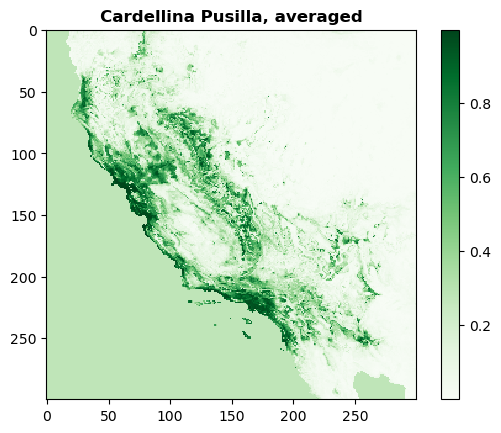

In [37]:
from pylab import plt
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

import rasterio
distr_rf = rasterio.open("outputs/rf-images/probability_1.0.tif").read(1)
distr_et = rasterio.open("outputs/et-images/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open("outputs/xgb-images/probability_1.tif").read(1)
distr_lgbm =  rasterio.open("outputs/lgbm-images/probability_1.0.tif").read(1)
distr_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4  

plotit(distr_averaged, "Cardellina Pusilla, averaged", cmap="Greens")